In [44]:
import os
from pathlib import Path
import numpy as np
import time
from scipy.optimize import minimize
from simsopt._core.optimizable import load
from simsopt.geo import ArclengthVariation
from simsopt.geo.surfacerzfourier import SurfaceRZFourier
from simsopt.objectives.fluxobjective import SquaredFlux
from simsopt.objectives.utilities import QuadraticPenalty
from simsopt.geo.curve import curves_to_vtk, create_equally_spaced_curves, create_equally_spaced_windowpane_curves
from simsopt.field.biotsavart import BiotSavart
from simsopt.field.coil import Current, coils_via_symmetries, ScaledCurrent, apply_symmetries_to_curves
from simsopt.geo.curveobjectives import CurveLength, CurveCurveDistance, \
    MeanSquaredCurvature, LpCurveCurvature, CurveSurfaceDistance, LinkingNumber

from simsopt.geo import SurfaceSurfaceDistance
from simsopt.field import SurfaceClassifier, \
    particles_to_vtk, compute_fieldlines, LevelsetStoppingCriterion, plot_poincare_data

import matplotlib.pyplot as plt

from simsopt.geo import CurveCWSFourier
from simsopt.geo import Curve2D
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

from pystellplot.Paraview import coils_to_vtk, surf_to_vtk

%matplotlib widget

In [45]:
# Number of unique coil shapes, i.e. the number of coils per half field period:
# (Since the configuration has nfp = 2, multiply by 4 to get the total number of coils.)
ncoils = 5

# Major radius for the initial circular coils:
R0 = 1.0

# Minor radius for the initial circular coils:
R1 = 0.5

# Number of Fourier modes describing each Cartesian component of each coil:
order = 7

# Weight on the curve lengths in the objective function. We use the `Weight`
# class here to later easily adjust the scalar value and rerun the optimization
# without having to rebuild the objective.
LENGTH_WEIGHT = 0.0156434465

# Threshold and weight for the coil-to-coil distance penalty in the objective function:
CC_THRESHOLD = 0.08
CC_WEIGHT = 156.434465

# Threshold and weight for the coil-to-surface distance penalty in the objective function:
CS_THRESHOLD = 0.12
CS_WEIGHT = 1564.34465

# Threshold and weight for the curvature penalty in the objective function:
CURVATURE_THRESHOLD = 12.
CURVATURE_WEIGHT = 0.000000156434465

# Threshold and weight for the mean squared curvature penalty in the objective function:
MSC_THRESHOLD = 11
MSC_WEIGHT = 1.10e-08

# Port size relevant weights
wport = 0
wdd = 1E6
#wco = 1E1
#wph = 1E3
warc = 1E-1
wufp = 1E-1

# Number of iterations to perform:
MAXITER =  400

# File for the desired boundary magnetic surface:
filename = '/Users/antoinebaillod/Projects/Accessibilty/configurations/qh_landreman_paul/wiedman_coils/input.LandremanPaul2021_QH'
#filename = 'input.nfp2_QA'

# Directory for output
OUT_DIR = f"./output/"
os.makedirs(OUT_DIR, exist_ok=True)

In [46]:
# Initialize the boundary magnetic surface:
nphi = 200
ntheta = 32
s = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
fulls = SurfaceRZFourier.from_vmec_input(filename, range="full torus", nphi=nphi, ntheta=ntheta)
s.fix_all()
fulls.fix_all()

# Create the initial tf coils:
base_tf_curves = create_equally_spaced_curves(ncoils, s.nfp, stellsym=True, R0=R0, R1=R1, order=order, numquadpoints=512) 
base_tf_currents = [Current(1e5) for _ in range(ncoils)]

tf_coils = coils_via_symmetries(base_tf_curves, base_tf_currents, s.nfp, True)
tf_curves = [c.curve for c in tf_coils]

for c in tf_coils:
    c.unfix_all()
tf_coils[0].current.fix_all()

In [47]:
s.major_radius()

0.9971973709763768

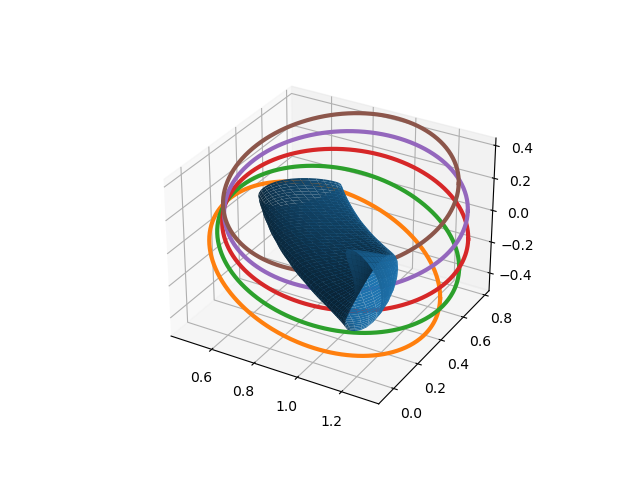

In [48]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
s.plot(ax=ax,show=False,close=True)
for c in base_tf_curves:
    c.plot(ax=ax,show=False,linewidth=3)

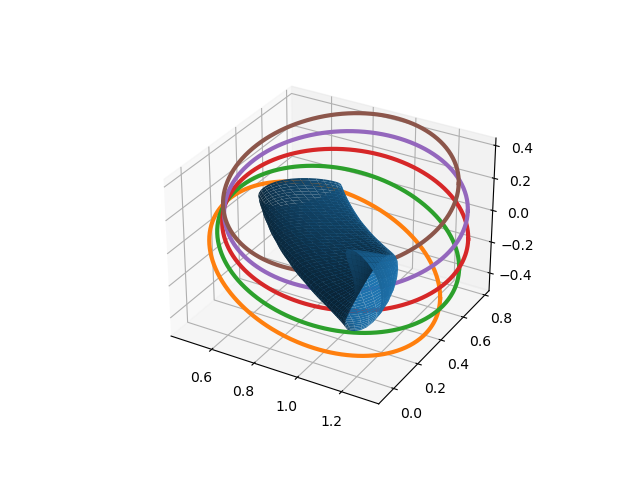

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
s.plot(ax=ax,show=False,close=True)
for c in base_tf_curves:
    c.plot(ax=ax,show=False,linewidth=3)

/var/folders/2t/kl_73rbx6v5g_wjy89yslg7r0000gn/T/ipykernel_40904/170332360.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


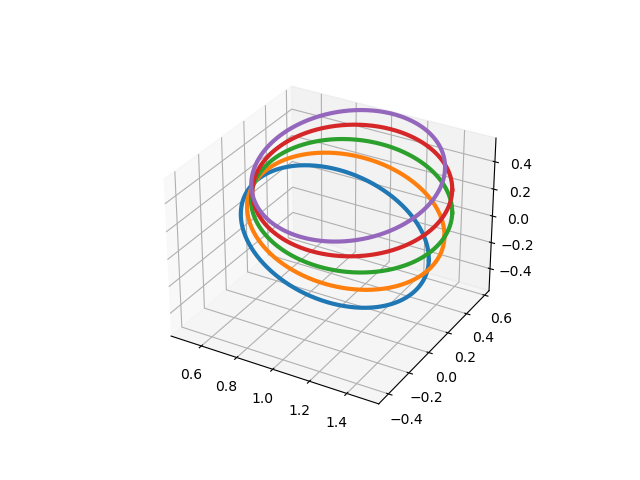

In [50]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for c in base_tf_curves:
    c.plot(ax=ax,show=False,linewidth=3)

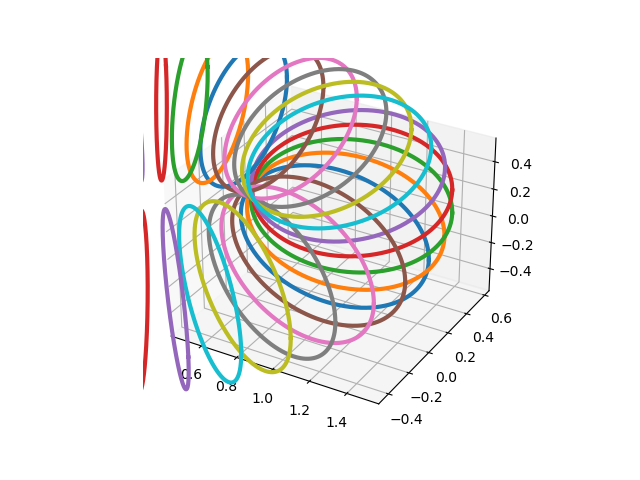

In [51]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for c in tf_coils:
    c.curve.plot(ax=ax,show=False,linewidth=3)

In [52]:
#Define one port

port_order = 2
port_qpts = 64

c2dport = Curve2D(port_qpts, port_order )
port_curve = CurveCWSFourier(
    c2dport,
    s
)

c2dport.fix_all()

full_port_curves = apply_symmetries_to_curves( [port_curve], s.nfp, True )

nfp = s.nfp
dphi = 1/(2*nfp) * 1/ncoils
iphi0 = 0
port_curve.curve2d.set('phic(0)', iphi0*dphi)
port_curve.curve2d.set('phic(1)', dphi/3.0)
port_curve.curve2d.set('thetac(0)', 0.0)
port_curve.curve2d.set('thetas(1)', 0.05)

In [53]:
full_coils = tf_coils
full_curves = [c.curve for c in full_coils]

bs = BiotSavart(full_coils)
bs.set_points(s.gamma().reshape((-1, 3)))

curves_to_vtk(tf_curves, OUT_DIR + "tf_curves_init")

curves_to_vtk(full_port_curves, OUT_DIR + "port_curves_init")
surf_to_vtk(OUT_DIR + "plasma_bnd_init", bs, s)

Text(0, 0.5, 'z')

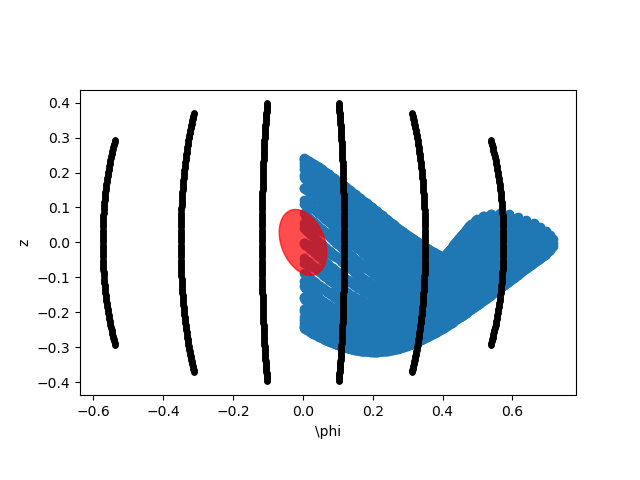

In [54]:
def project(x, x0):
    phic = np.arctan2(x0[1], x0[0])
    unit_normal = np.array([np.cos(phic), np.sin(phic), np.zeros(phic.shape)])
    unit_tangent = np.array([-np.sin(phic), np.cos(phic), np.zeros(phic.shape)])
    unit_z = np.array([np.zeros(phic.shape), np.zeros(phic.shape), np.ones(phic.shape)])

    M = np.array([unit_normal,unit_tangent,unit_z]).transpose()
    invM = np.linalg.inv(M)
    
    return np.einsum('ij,...j->...i',invM,x-x0)

x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(s.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in full_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

In [55]:
# Define the individual terms objective function:
## Quad flux and coil reguularization
Jf = SquaredFlux(s, bs)
Jls = [CurveLength(c) for c in base_tf_curves]
Jccdist = CurveCurveDistance(tf_curves, CC_THRESHOLD, num_basecurves=ncoils)
Jcsdist = CurveSurfaceDistance(base_tf_curves, s, CS_THRESHOLD)
#Jcwsdist = CurveSurfaceDistance(base_tf_curves, v, 0.05)
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_tf_curves]
Jmscs = [MeanSquaredCurvature(c) for c in base_tf_curves]
linkNum = LinkingNumber(tf_curves)

JF = Jf \
    + LENGTH_WEIGHT * QuadraticPenalty(sum(Jls), 2.6*ncoils) \
    + CC_WEIGHT * Jccdist \
    + CS_WEIGHT * Jcsdist \
    + CURVATURE_WEIGHT * sum(Jcs) \
    + MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs) \
    + QuadraticPenalty(linkNum, 0.1) \
    + linkNum

# Port relavant penalties
Jxyarea = ProjectedEnclosedArea( port_curve, projection='zphi' )
Jccxydist = ProjectedCurveCurveDistance( tf_curves, port_curve, 0.05, projection='zphi' )
Jconvex = ProjectedCurveConvexity( port_curve, projection='zphi' )
Jarc = ArclengthVariation( port_curve )
Jufp = DirectedFacingPort(port_curve, projection='r')
Jport = -1 * Jxyarea + wdd * Jccxydist + warc * Jarc + wufp * Jufp #+ wco * Jconvex

JF += wport * Jport

# Form the total objective function. To do this, we can exploit the
# fact that Optimizable objects with J() and dJ() functions can be
# multiplied by scalars and added:

#J= Jport

# We don't have a general interface in SIMSOPT for optimisation problems that
# are not in least-squares form, so we write a little wrapper function that we
# pass directly to scipy.optimize.minimize


def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    MaxBdotN = np.max(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    mean_AbsB = np.mean(bs.AbsB())

    
    A = Jxyarea.J()
    CC = Jccxydist.J()
    arc = Jarc.J()
    #convex = Jconvex.J()
    
    outstr = f"J={J:.1e}, Jf={jf:.1e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in full_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}, C-S-Sep={Jcsdist.shortest_distance():.2f}"
    outstr += f", ║∇J║={np.linalg.norm(grad):.1e}"
    outstr += f", ⟨B·n⟩/|B|={BdotN/mean_AbsB:.1e}"
    outstr += f", (Max B·n)/|B|={MaxBdotN/mean_AbsB:.1e}"
    #outstr += f", Link Number = {linkNum.J()}\n"
    outstr += f"Jport={Jport.J():.2E}, Area={A:.2E}, Coil-coil dist={CC:.2E}, Arc penalty={arc:.2E}\n"#, Convex={convex:.2E}"
    print(outstr)
    return J, grad

In [56]:
Jcsdist.shortest_distance()

0.15734805892232928

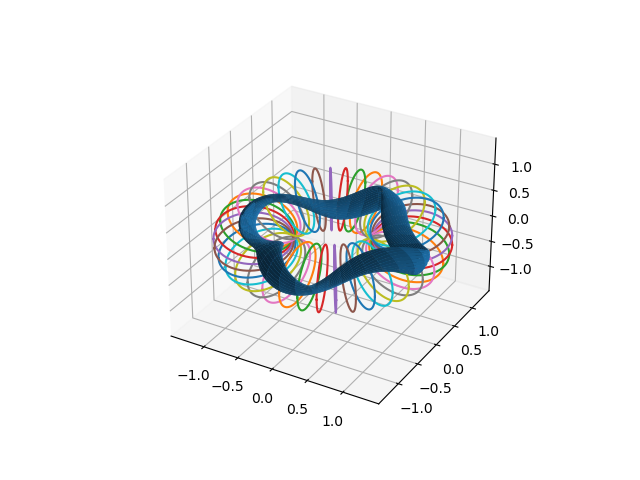

In [57]:
fulls.plot(show=False, close=True)
ax = plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

Text(0.5, 0, '$\\theta$')

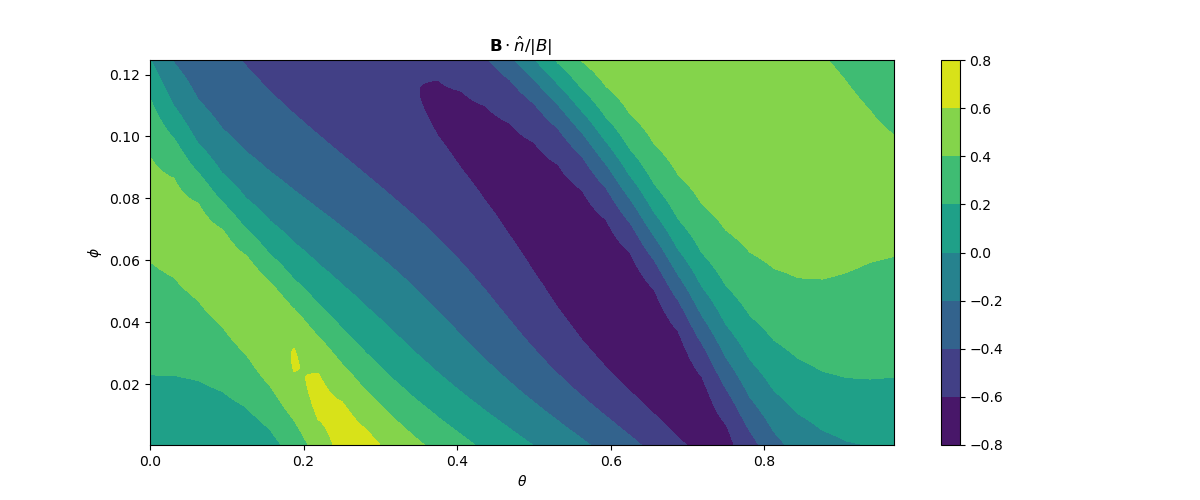

In [58]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

In [59]:
JF.dof_names

['Current22:x0',
 'Current23:x0',
 'Current24:x0',
 'Current25:x0',
 'CurveXYZFourier21:xc(0)',
 'CurveXYZFourier21:xs(1)',
 'CurveXYZFourier21:xc(1)',
 'CurveXYZFourier21:xs(2)',
 'CurveXYZFourier21:xc(2)',
 'CurveXYZFourier21:xs(3)',
 'CurveXYZFourier21:xc(3)',
 'CurveXYZFourier21:xs(4)',
 'CurveXYZFourier21:xc(4)',
 'CurveXYZFourier21:xs(5)',
 'CurveXYZFourier21:xc(5)',
 'CurveXYZFourier21:xs(6)',
 'CurveXYZFourier21:xc(6)',
 'CurveXYZFourier21:xs(7)',
 'CurveXYZFourier21:xc(7)',
 'CurveXYZFourier21:yc(0)',
 'CurveXYZFourier21:ys(1)',
 'CurveXYZFourier21:yc(1)',
 'CurveXYZFourier21:ys(2)',
 'CurveXYZFourier21:yc(2)',
 'CurveXYZFourier21:ys(3)',
 'CurveXYZFourier21:yc(3)',
 'CurveXYZFourier21:ys(4)',
 'CurveXYZFourier21:yc(4)',
 'CurveXYZFourier21:ys(5)',
 'CurveXYZFourier21:yc(5)',
 'CurveXYZFourier21:ys(6)',
 'CurveXYZFourier21:yc(6)',
 'CurveXYZFourier21:ys(7)',
 'CurveXYZFourier21:yc(7)',
 'CurveXYZFourier21:zc(0)',
 'CurveXYZFourier21:zs(1)',
 'CurveXYZFourier21:zc(1)',
 'CurveX

In [77]:
0.05**2

0.0025000000000000005

In [17]:
dofs = JF.x
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)

J=4.9e-01, Jf=4.3e-01, ⟨B·n⟩=3.2e-01, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.08, C-S-Sep=0.16, ║∇J║=1.2e+00, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01Jport=-8.53E-03, Area=9.57E-03, Coil-coil dist=3.88E-10, Arc penalty=6.49E-03

J=1.6e+03, Jf=1.0e-02, ⟨B·n⟩=5.0e-02, Len=sum([3.0, 3.2, 3.6, 3.9, 4.1])=17.8, ϰ=[6.4, 6.2, 5.4, 5.1, 4.7, 6.4, 6.2, 5.4, 5.1, 4.7, 6.4, 6.2, 5.4, 5.1, 4.7, 6.4, 6.2, 5.4, 5.1, 4.7, 6.4, 6.2, 5.4, 5.1, 4.7, 6.4, 6.2, 5.4, 5.1, 4.7, 6.4, 6.2, 5.4, 5.1, 4.7, 6.4, 6.2, 5.4, 5.1, 4.7], ∫ϰ²/L=[13.3, 11.1, 8.4, 6.8, 6.4], C-C-Sep=0.00, C-S-Sep=0.14, ║∇J║=3.1e+00, ⟨B·n⟩/|B|=7.8e-02, (Max B·n)/|B|=3.6e-01Jport=-8.92E-03, Area=9.57E-03, Coil-coil dist=0.00E+00, Arc penalty=6.49E-03

J=4.9e-01, Jf=4.3e-01, ⟨B·n⟩=3.2e-01, Len=su

In [18]:
print(res.message)

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


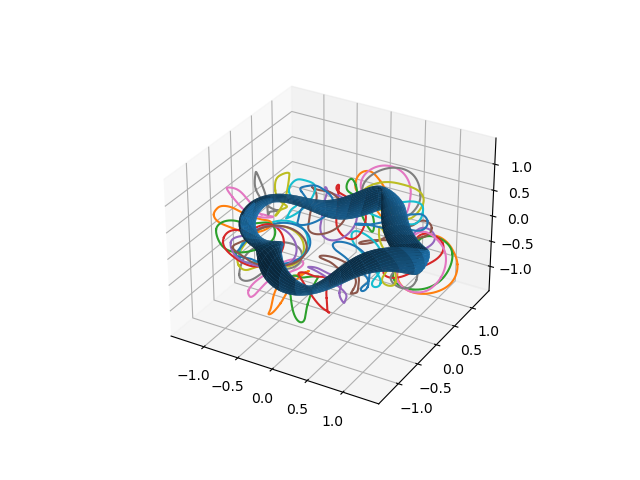

In [19]:
fulls.plot(show=False, close=True)
ax = plt.gca()
for c in tf_curves:
    c.plot(ax=ax, show=False)

Text(0.5, 0, '$\\theta$')

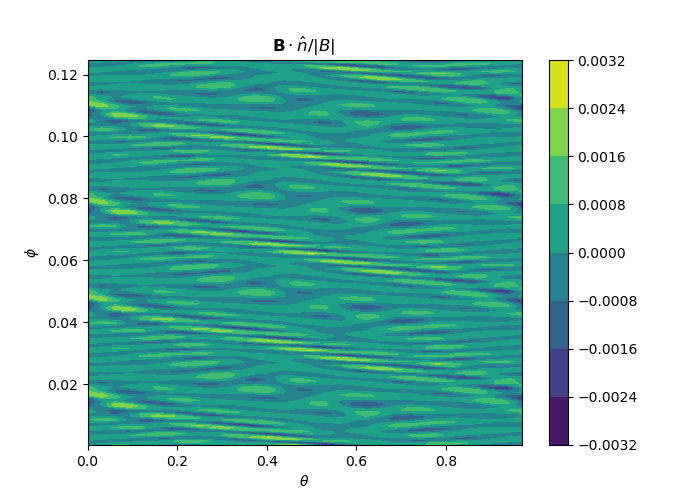

In [20]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(fulls.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * fulls.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

Text(0, 0.5, 'z')

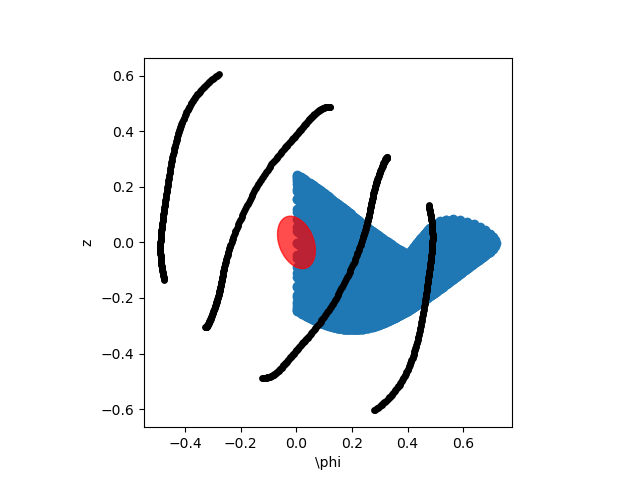

In [21]:
x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(s.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in full_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

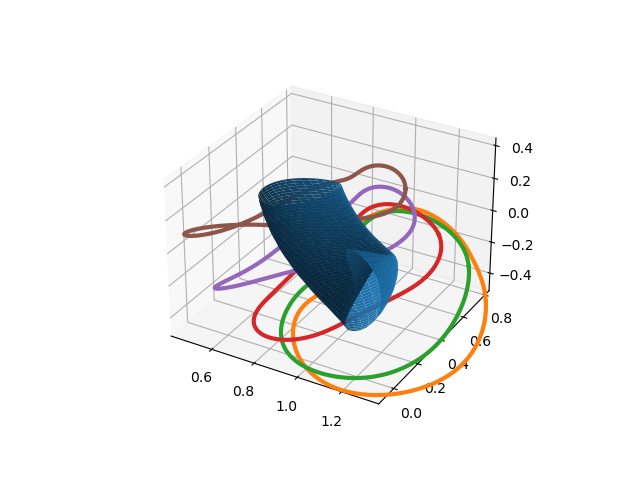

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
s.plot(ax=ax,show=False,close=True)
for c in base_tf_curves:
    c.plot(ax=ax,show=False,linewidth=3)


In [23]:
from pystellplot.Paraview import coils_to_vtk, surf_to_vtk

curves_to_vtk(tf_curves, OUT_DIR + f"curves_wport={wport:.2E}")
surf_to_vtk(OUT_DIR + "surf_opt_short", bs, fulls)
bs.save(OUT_DIR + f'biotsavart_wport={wport:.2E}.json');

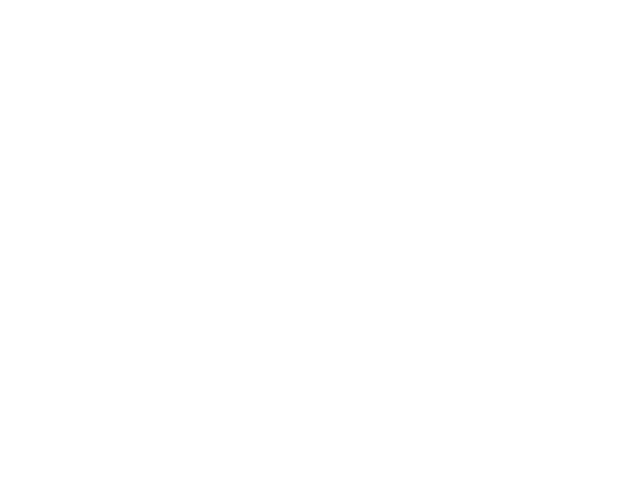

In [24]:
from simsopt.field import SurfaceClassifier, \
    particles_to_vtk, compute_fieldlines, LevelsetStoppingCriterion, plot_poincare_data


# Run and plot Poincare section
surf = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
surf1 = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
surf1.extend_via_normal(0.1)
nfp = surf.nfp

Rmaj = surf.major_radius()
r0 = surf.minor_radius()
#sc_fieldline = SurfaceClassifier(surf1, h=0.01, p=3)
nfieldlines = 20
tmax_fl = 2500
degree = 4

def trace_fieldlines(bfield,label):
    # Set up initial conditions - 
    R0 = np.linspace(1.15,1.25, nfieldlines)
    Z0 = np.zeros(nfieldlines)
    phis = [(i/4)*(2*np.pi/nfp) for i in range(4)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis)#, stopping_criteria=[LevelsetStoppingCriterion(sc_fieldline.dist)])
    plot_poincare_data(fieldlines_phi_hits, phis, 'wiedman/poincare_final', dpi=150,surf=surf,mark_lost=True)
    return fieldlines_phi_hits

hits = trace_fieldlines(bs, 'vmec')